2. Implement a MLP for classification. (total 40 marks)
a. Flatten the images into a single dimensional vector before feeding it to the model.
(1 marks)
b. Write a pre-processing module for all the images. (3 marks)
c. Write the Forward pass from scratch. Use of the inbuilt forward pass function will
result in 0 marks for this sub-question. (8 marks)
d. Write the Backward pass from scratch. Use the inbuilt back propagation function
will result in 0 marks for this sub-question (12 marks)
e. Write the module for cross entropy loss (1 marks)
f. Experiment with different hyperparameters like number of layers, dropout,
objective function, etc. and settle with a combination which performs the best for
the given problem. (15 Marks)

In [ ]:
import numpy as np

# Defining functins from scracth using numpy
def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)

def cross_entropy_loss(y_true, y_pred):
    n_samples = y_true.shape[0]
    y_pred = np.clip(y_pred, 1e-12, 1.0)  # Clip predictions to prevent log(0)
    log_p = -np.log(y_pred[range(n_samples), y_true.argmax(axis=1)])
    loss = np.sum(log_p) / n_samples
    return loss

def cross_entropy_loss_derivative(y_true, y_pred):
    n_samples = y_true.shape[0]
    grad = y_pred.copy()
    grad[range(n_samples), y_true.argmax(axis=1)] -= 1
    grad = grad / n_samples
    return grad

def batch_norm_forward(x, gamma, beta, eps=1e-8):
    mean = np.mean(x, axis=0)
    var = np.var(x, axis=0)
    x_norm = (x - mean) / np.sqrt(var + eps)
    out = gamma * x_norm + beta
    cache = (x, x_norm, mean, var, gamma, beta, eps)
    return out, cache

def batch_norm_backward(dout, cache):
    x, x_norm, mean, var, gamma, beta, eps = cache
    N, D = x.shape

    dbeta = np.sum(dout, axis=0)
    dgamma = np.sum(dout * x_norm, axis=0)
    dx_norm = dout * gamma
    dvar = np.sum(dx_norm * (x - mean) * -0.5 * np.power(var + eps, -1.5), axis=0)
    dmean = np.sum(dx_norm * -1.0 / np.sqrt(var + eps), axis=0) + dvar * np.sum(-2.0 * (x - mean), axis=0) / N
    dx = dx_norm * 1.0 / np.sqrt(var + eps) + dvar * 2.0 * (x - mean) / N + dmean / N

    return dx, dgamma, dbeta

#MLP for classification. Using Adam and SGD implementation from scratch
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, dropout_rates=None):
        self.learning_rate = learning_rate
        self.dropout_rates = dropout_rates if dropout_rates else [0.1, 0.0005, 0.1, 0.0002, 0.1, 0.000005]
        self.layers = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2. / self.layers[i]) for i in range(len(self.layers)-1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers)-1)]
        self.gammas = [np.ones((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.betas = [np.zeros((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.velocities = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]
        self.squares = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]

    def forward(self, x):
        self.caches = []
        self.norm_caches = []
        self.dropouts = []

        x = x * (np.random.rand(*x.shape) > self.dropout_rates[0]) / (1 - self.dropout_rates[0])
        self.dropouts.append(x)

        for i in range(len(self.weights) - 1):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            norm_z, norm_cache = batch_norm_forward(z, self.gammas[i], self.betas[i])
            a = leaky_relu(norm_z)
            dropout_mask = (np.random.rand(*a.shape) > self.dropout_rates[i+1]) / (1 - self.dropout_rates[i+1])
            a = a * dropout_mask
            self.caches.append((x, z, norm_cache))
            self.dropouts.append(dropout_mask)
            x = a

        z = np.dot(x, self.weights[-1]) + self.biases[-1]
        a = softmax(z)
        self.caches.append((x, z))
        return a

    def backward(self, y_true, y_pred):
        m = y_true.shape[0]
        grads = {}
        d_a = cross_entropy_loss_derivative(y_true, y_pred)

        for i in reversed(range(len(self.weights))):
            x, z, *cache = self.caches[i]
            if i == len(self.weights) - 1:
                d_z = d_a
            else:
                d_z = d_a * leaky_relu_derivative(z)
                d_z, dgamma, dbeta = batch_norm_backward(d_z, cache[0])
                grads[f'dgamma{i}'] = dgamma
                grads[f'dbeta{i}'] = dbeta

            grads[f'dw{i}'] = np.dot(x.T, d_z) / m
            grads[f'db{i}'] = np.sum(d_z, axis=0, keepdims=True) / m

            # Gradient clipping
            grads[f'dw{i}'] = np.clip(grads[f'dw{i}'], -1, 1)
            grads[f'db{i}'] = np.clip(grads[f'db{i}'], -1, 1)

            if i != 0:
                d_a = np.dot(d_z, self.weights[i].T)
                if len(self.dropouts) > i:
                    d_a = d_a * self.dropouts[i]

        return grads

    def update_weights(self, grads, t, optimizer='adam'):
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        lr = self.learning_rate
        for i in range(len(self.weights)):
            if optimizer == 'adam':
                self.velocities[i]['dw'] = beta1 * self.velocities[i]['dw'] + (1 - beta1) * grads[f'dw{i}']
                self.velocities[i]['db'] = beta1 * self.velocities[i]['db'] + (1 - beta1) * grads[f'db{i}']
                self.squares[i]['dw'] = beta2 * self.squares[i]['dw'] + (1 - beta2) * (grads[f'dw{i}'] ** 2)
                self.squares[i]['db'] = beta2 * self.squares[i]['db'] + (1 - beta2) * (grads[f'db{i}'] ** 2)
                m_hat_dw = self.velocities[i]['dw'] / (1 - beta1 ** t)
                m_hat_db = self.velocities[i]['db'] / (1 - beta1 ** t)
                v_hat_dw = self.squares[i]['dw'] / (1 - beta2 ** t)
                v_hat_db = self.squares[i]['db'] / (1 - beta2 ** t)
                self.weights[i] -= lr * m_hat_dw / (np.sqrt(v_hat_dw) + eps)
                self.biases[i] -= lr * m_hat_db / (np.sqrt(v_hat_db) + eps)
                if i < len(self.weights) - 1:
                    v_hat_gamma = self.squares[i]['dgamma'] / (1 - beta2 ** t)  # Fix for gammas
                    v_hat_beta = self.squares[i]['dbeta'] / (1 - beta2 ** t)  # Fix for betas
                    self.gammas[i] -= lr * grads[f'dgamma{i}'] / (np.sqrt(v_hat_gamma) + eps)
                    self.betas[i] -= lr * grads[f'dbeta{i}'] / (np.sqrt(v_hat_beta) + eps)
            else:  # SGD
                self.weights[i] -= lr * grads[f'dw{i}']
                self.biases[i] -= lr * grads[f'db{i}']
                if i < len(self.weights) - 1:
                    self.gammas[i] -= lr * grads[f'dgamma{i}']
                    self.betas[i] -= lr * grads[f'dbeta{i}']

    def train(self, x_train, y_train, x_val, y_val, epochs=50, batch_size=128):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            optimizer = 'sgd' if epoch < 30 else 'adam'  # Switch to adam after 30 epochs
            for i in range(0, x_train.shape[0], batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward(x_batch)
                grads = self.backward(y_batch, y_pred)
                self.update_weights(grads, epoch + 1, optimizer=optimizer)

            train_loss, train_acc = self.evaluate(x_train, y_train)
            val_loss, val_acc = self.evaluate(x_val, y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        return train_losses, val_losses, train_accuracies, val_accuracies

    def evaluate(self, x, y):
        y_pred = self.forward(x)
        loss = cross_entropy_loss(y, y_pred)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == y.argmax(axis=1))
        return loss, accuracy

    def predict(self, x):
        y_pred = self.forward(x)
        return np.argmax(y_pred, axis=1)


The MLP, using features extracted from the CNN!  
3. Build a small CNN model consisting of 5 convolution layers. Each convolution
layer would be followed by a ReLU activation and a max pooling layer. (10 Marks
)
b. Experiment with different kernel size, number of kernel each layer (keep number
of filter same in each layer, double it in each layer etc) and settle with a
combination which performs the best for the given problem. (10 Marks)
c. Try different weight initialization methods (random, Xavier, He) (5 Marks)
d. After extracting feature from CNN model use MLP for classification (use code
from question 2) (15 Marks

Epoch 1/20, Train Loss: 0.8176, Val Loss: 0.4418
Epoch 2/20, Train Loss: 0.3834, Val Loss: 0.3706
Epoch 3/20, Train Loss: 0.3395, Val Loss: 0.3397
Epoch 4/20, Train Loss: 0.3076, Val Loss: 0.3382
Epoch 5/20, Train Loss: 0.2885, Val Loss: 0.3123
Epoch 6/20, Train Loss: 0.2741, Val Loss: 0.3033
Epoch 7/20, Train Loss: 0.2611, Val Loss: 0.2979
Epoch 8/20, Train Loss: 0.2503, Val Loss: 0.2751
Epoch 9/20, Train Loss: 0.2385, Val Loss: 0.2676
Epoch 10/20, Train Loss: 0.2309, Val Loss: 0.2656
Epoch 11/20, Train Loss: 0.1793, Val Loss: 0.2300
Epoch 12/20, Train Loss: 0.1653, Val Loss: 0.2325
Epoch 13/20, Train Loss: 0.1592, Val Loss: 0.2316
Epoch 14/20, Train Loss: 0.1538, Val Loss: 0.2223
Epoch 15/20, Train Loss: 0.1480, Val Loss: 0.2317
Epoch 16/20, Train Loss: 0.1423, Val Loss: 0.2328
Epoch 17/20, Train Loss: 0.1388, Val Loss: 0.2315
Epoch 18/20, Train Loss: 0.1343, Val Loss: 0.2415
Epoch 19/20, Train Loss: 0.1312, Val Loss: 0.2323
Epoch 20/20, Train Loss: 0.1279, Val Loss: 0.2292
Epoch 1/3

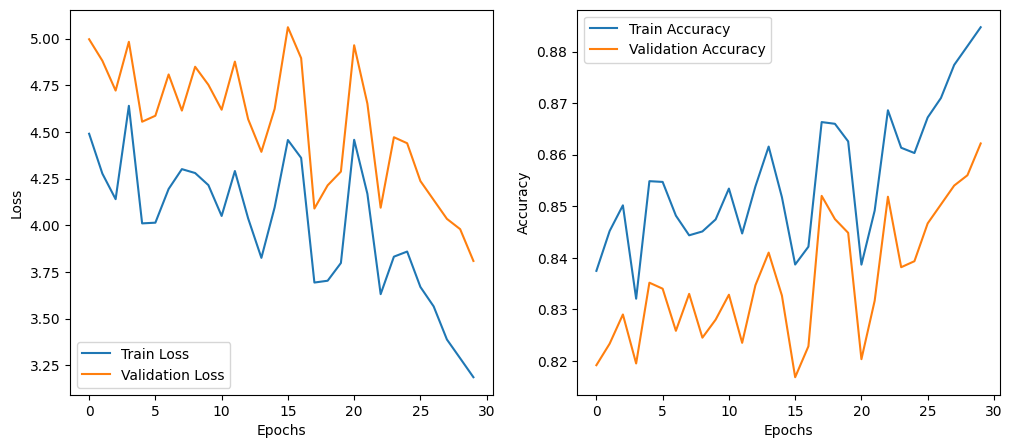

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

#  Initial feature transforms with data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Downloading and loading the training data
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
]))

# dividing dataset into training and validation sets (80-10-10) - This to change further to experiment with 75%, 25%
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_set, val_set, _ = random_split(train_dataset, [train_size, val_size, test_size])

# Create data loaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=True)

# The He , Xavier and Random weight initialization methods to be tested separately
def init_weights_random(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.weight.data.normal_(0, 0.01)
        if m.bias is not None:
            m.bias.data.zero_()

def init_weights_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.zero_()

def init_weights_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            m.bias.data.zero_()

# the CNN architecture  definition with BatchNorm and Dropout - experiment with Dropouts / Kernel(smaller the better )
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(512)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28x28 -> 14x14
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14x14 -> 7x7
        x = F.relu(self.bn3(self.conv3(x)))  # 7x7 -> 7x7
        x = F.relu(self.bn4(self.conv4(x)))  # 7x7 -> 7x7
        x = self.pool(F.relu(self.bn5(self.conv5(x))))  # 7x7 -> 3x3
        x = x.view(x.size(0), -1)  # Flatten the tensor
        return x

# Instantiate the CNN model and initialize weights # taking Xavier - can try with He and Random
cnn = CNN()
cnn.apply(init_weights_xavier)

# Function to evaluate model accuracy
def evaluate_model(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return accuracy

# Define the training loop for the CNN # experiemnet with num of epocs and learning rates
def train_cnn(model, train_loader, val_loader, num_epochs=25, learning_rate=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        train_losses.append(running_loss / len(train_loader))
        val_loss = 0.0
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_losses.append(val_loss / len(val_loader))
        scheduler.step()
        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}')
    return train_losses, val_losses

# Training the CNN model
train_losses, val_losses = train_cnn(cnn, train_loader, val_loader, num_epochs=20, learning_rate=0.01)

# Q3 -> d requirememnt Extract features from the CNN and feed to MLP
def extract_features(model, data_loader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, label in data_loader:
            output = model(images)
            features.append(output)
            labels.append(label)
    features = torch.cat(features)
    labels = torch.cat(labels)
    return features, labels

train_features, train_labels = extract_features(cnn, train_loader)
val_features, val_labels = extract_features(cnn, val_loader)
test_features, test_labels = extract_features(cnn, test_loader)

# Convert features to numpy arrays for MLP
train_features = train_features.numpy()
val_features = val_features.numpy()
test_features = test_features.numpy()

train_labels = train_labels.numpy()
val_labels = val_labels.numpy()
test_labels = test_labels.numpy()

# One-hot encode the labels
def one_hot_encode(labels, num_classes=10):
    return np.eye(num_classes)[labels]

train_labels_one_hot = one_hot_encode(train_labels)
val_labels_one_hot = one_hot_encode(val_labels)
test_labels_one_hot = one_hot_encode(test_labels)

# MLP class definition (from the previous code as defined in Q2 above)
class MLP:
    def __init__(self, input_size, hidden_sizes, output_size, learning_rate=0.001, dropout_rates=None):
        self.learning_rate = learning_rate
        self.dropout_rates = dropout_rates if dropout_rates else [0.1, 0, 0.1, 0, 0.1, 0]
        self.layers = [input_size] + hidden_sizes + [output_size]
        self.weights = [np.random.randn(self.layers[i], self.layers[i+1]) * np.sqrt(2. / self.layers[i]) for i in range(len(self.layers)-1)]
        self.biases = [np.zeros((1, self.layers[i+1])) for i in range(len(self.layers)-1)]
        self.gammas = [np.ones((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.betas = [np.zeros((self.layers[i+1],)) for i in range(len(self.layers)-2)]
        self.velocities = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]
        self.squares = [{'dw': 0, 'db': 0, 'dgamma': 0, 'dbeta': 0} for _ in range(len(self.weights))]

    def forward(self, x):
        self.caches = []
        self.norm_caches = []
        self.dropouts = []

        x = x * (np.random.rand(*x.shape) > self.dropout_rates[0]) / (1 - self.dropout_rates[0])
        self.dropouts.append(x)

        for i in range(len(self.weights) - 1):
            z = np.dot(x, self.weights[i]) + self.biases[i]
            norm_z, norm_cache = batch_norm_forward(z, self.gammas[i], self.betas[i])
            a = leaky_relu(norm_z)
            dropout_mask = (np.random.rand(*a.shape) > self.dropout_rates[i+1]) / (1 - self.dropout_rates[i+1])
            a = a * dropout_mask
            self.caches.append((x, z, norm_cache))
            self.dropouts.append(dropout_mask)
            x = a

        z = np.dot(x, self.weights[-1]) + self.biases[-1]
        a = softmax(z)
        self.caches.append((x, z))
        return a

    def backward(self, y_true, y_pred):
        m = y_true.shape[0]
        grads = {}
        d_a = cross_entropy_loss_derivative(y_true, y_pred)

        for i in reversed(range(len(self.weights))):
            x, z, *cache = self.caches[i]
            if i == len(self.weights) - 1:
                d_z = d_a
            else:
                d_z = d_a * leaky_relu_derivative(z)
                d_z, dgamma, dbeta = batch_norm_backward(d_z, cache[0])
                grads[f'dgamma{i}'] = dgamma
                grads[f'dbeta{i}'] = dbeta

            grads[f'dw{i}'] = np.dot(x.T, d_z) / m
            grads[f'db{i}'] = np.sum(d_z, axis=0, keepdims=True) / m

            # Gradient clipping
            grads[f'dw{i}'] = np.clip(grads[f'dw{i}'], -1, 1)
            grads[f'db{i}'] = np.clip(grads[f'db{i}'], -1, 1)

            if i != 0:
                d_a = np.dot(d_z, self.weights[i].T)
                if len(self.dropouts) > i:
                    d_a = d_a * self.dropouts[i]

        return grads

    def update_weights(self, grads, t, optimizer='adam'):
        beta1, beta2, eps = 0.9, 0.999, 1e-8
        lr = self.learning_rate
        for i in range(len(self.weights)):
            if optimizer == 'adam':
                self.velocities[i]['dw'] = beta1 * self.velocities[i]['dw'] + (1 - beta1) * grads[f'dw{i}']
                self.velocities[i]['db'] = beta1 * self.velocities[i]['db'] + (1 - beta1) * grads[f'db{i}']
                self.squares[i]['dw'] = beta2 * self.squares[i]['dw'] + (1 - beta2) * (grads[f'dw{i}'] ** 2)
                self.squares[i]['db'] = beta2 * self.squares[i]['db'] + (1 - beta2) * (grads[f'db{i}'] ** 2)
                m_hat_dw = self.velocities[i]['dw'] / (1 - beta1 ** t)
                m_hat_db = self.velocities[i]['db'] / (1 - beta1 ** t)
                v_hat_dw = self.squares[i]['dw'] / (1 - beta2 ** t)
                v_hat_db = self.squares[i]['db'] / (1 - beta2 ** t)
                self.weights[i] -= lr * m_hat_dw / (np.sqrt(v_hat_dw) + eps)
                self.biases[i] -= lr * m_hat_db / (np.sqrt(v_hat_db) + eps)
                if i < len(self.weights) - 1:
                    v_hat_gamma = self.squares[i]['dgamma'] / (1 - beta2 ** t)  # Fix for gammas
                    v_hat_beta = self.squares[i]['dbeta'] / (1 - beta2 ** t)  # Fix for betas
                    self.gammas[i] -= lr * grads[f'dgamma{i}'] / (np.sqrt(v_hat_gamma) + eps)
                    self.betas[i] -= lr * grads[f'dbeta{i}'] / (np.sqrt(v_hat_beta) + eps)
            else:  # SGD
                self.weights[i] -= lr * grads[f'dw{i}']
                self.biases[i] -= lr * grads[f'db{i}']
                if i < len(self.weights) - 1:
                    self.gammas[i] -= lr * grads[f'dgamma{i}']
                    self.betas[i] -= lr * grads[f'dbeta{i}']

    def train(self, x_train, y_train, x_val, y_val, epochs=30, batch_size=64):
        train_losses = []
        val_losses = []
        train_accuracies = []
        val_accuracies = []

        for epoch in range(epochs):
            optimizer = 'adam' if epoch < 20 else 'sgd'  # Switch to SGD after 20 epochs
            for i in range(0, x_train.shape[0], batch_size):
                x_batch = x_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                y_pred = self.forward(x_batch)
                grads = self.backward(y_batch, y_pred)
                self.update_weights(grads, epoch + 1, optimizer=optimizer)

            train_loss, train_acc = self.evaluate(x_train, y_train)
            val_loss, val_acc = self.evaluate(x_val, y_val)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            train_accuracies.append(train_acc)
            val_accuracies.append(val_acc)
            print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}')

        return train_losses, val_losses, train_accuracies, val_accuracies

    def evaluate(self, x, y):
        y_pred = self.forward(x)
        loss = cross_entropy_loss(y, y_pred)
        accuracy = np.mean(np.argmax(y_pred, axis=1) == y.argmax(axis=1))
        return loss, accuracy

    def predict(self, x):
        y_pred = self.forward(x)
        return np.argmax(y_pred, axis=1)

# Initialiing the MLP
input_size = 512 * 3 * 3  # Output size from the CNN's feature extractor
hidden_sizes = [512, 256, 128, 64]
output_size = 10

mlp = MLP(input_size, hidden_sizes, output_size, learning_rate=0.01, dropout_rates=[0.1, 0, 0.1, 0, 0.1, 0])

# Training finally the MLP using the features extracted from the CNN -> need to experiment on epochs
train_losses, val_losses, train_accuracies, val_accuracies = mlp.train(train_features, train_labels_one_hot, val_features, val_labels_one_hot, epochs=30)

# Evaluate the MLP on the test set
test_loss, test_accuracy = mlp.evaluate(test_features, test_labels_one_hot)
print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

# Plotting training and validation accuracy - plotting and testing with images
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
